In [1]:
import config
import time
import torch
import numpy as np
from glob import glob
import random
from pyrsimg import imgShow
from pyrsimg import crop2size
import matplotlib.pyplot as plt
from dataloader.loader import scene_dset
from dataloader.preprocess import read_normalize
from dataloader.parallel_loader import threads_scene_dset
from dataloader.img_aug import rotate, flip, numpy2tensor, torch_noise


In [2]:
## Data paths
### The whole dataset.
paths_scene = sorted(glob(config.dir_s2 + '/scene/*'))
paths_truth = [path_scene.replace('/scene/', '/truth/').replace('_6Bands', '').split('.')[0] + '_truth.tif' for path_scene in paths_scene]
### Select training part from the dataset.
id_scene = [i for i in range(len(paths_scene))]
id_tra_scene = list(set(id_scene) - set(config.i_valset))
paths_tra_scene, paths_tra_truth = [paths_scene[i] for i in id_tra_scene], [paths_truth[i] for i in id_tra_scene]
print(len(paths_tra_scene))
print(paths_tra_scene[0])


75
/home/xin/Developer-luo/WatSet/sentinel-2/scene/S2A_L2A_20190508_N0212_R078_6Bands_S3.tif


In [3]:
### -----data read & pre-processing------- ###
scene_list, truth_list = read_normalize(paths_img=paths_tra_scene, \
                            paths_truth=paths_tra_truth, max_bands=config.bands_max, min_bands=config.bands_min)
len(scene_list)
print(scene_list[0].shape)


(682, 807, 6)


### Single-thread data loading 
#### Generate pytorch dataloader


In [4]:
time_start = time.time()
tra_dset_single = scene_dset(scene_list=scene_list, truth_list=truth_list, \
                                                    transforms=config.transforms_tra, patch_size=[256, 256])
print('lenth of the single-thread loaded data:', len(tra_dset_single))
tra_loader_single = torch.utils.data.DataLoader(tra_dset_single, batch_size=8, shuffle=True)
print('time comsuming: ', time.time()-time_start)


lenth of the single-thread loaded data: 75
time comsuming:  0.0002791881561279297


#### Loops through the dataset.

In [6]:
num = 0
start = time.time()
for patch, truth in tra_loader_single:
    num += truth.shape[0]
    # print(num)
print('time/patch: %.3f, dset size: %.1i:' % ((time.time()-start)/num, num))
print('time/all_patch: %.3f ' % (time.time()-start))



time/patch: 0.023, dset size: 75:
time/all_patch: 1.749 


### Multi-thread data loading (Conclusion: a slight improvement in time comsuming.)
#### Generate pytorch dataloader


In [7]:
## ------ multi-threads data loading ------
time_start = time.time()
tra_dset_threads = threads_scene_dset(scene_list, truth_list, transforms=config.transforms_tra, num_thread=10)
print('lenth of the multi-theads loaded data:', len(tra_dset_threads))
tra_loader_threads = torch.utils.data.DataLoader(tra_dset_threads, batch_size=8, shuffle=True, num_workers=0)
print('time comsuming:  ', time.time()-time_start)


lenth of the multi-theads loaded data: 750
time comsuming:   11.292391061782837


In [8]:
num = 0
start = time.time()
for patch, truth in tra_loader_threads:
    num += truth.shape[0]
    # print(num)
print('time/patch: %.3f, dset size: %.1i:' % ((time.time()-start)/num, num))
print('time/all_patch: %.3f ' % (time.time()-start))


time/patch: 0.015, dset size: 750:
time/all_patch: 11.624 


### Test crop and data augmentation (Conclusion: The image cropping comsumes more time than patch augmentaion)

In [9]:
transforms = [rotate(prob=0.3), 
            flip(prob=0.3),  
            numpy2tensor(), 
            torch_noise(prob=0.3, std_min=0.001, std_max=0.1)]

patch_list, ptruth_list = [],[]
'''convert image to patches group'''
zip_data = list(zip(scene_list, truth_list))
for scene, truth in zip_data:
    start_0 = time.time()
    truth = truth[:,:, np.newaxis]
    scene_truth = np.concatenate((scene, truth), axis=-1)
    patch_ptruth = crop2size(img=scene_truth, channel_first=False).toSize(size=(256, 256))    
    patch, truth = patch_ptruth[:,:,0:-1], patch_ptruth[:,:,-1]
    patch = patch.transpose(2,0,1)   ### set the channel first
    start_1 = time.time()
    time_crop = start_1-start_0   ## Record the crop time.

    for transform in transforms:
        patch, truth = transform(patch, truth)
    time_aug = time.time()-start_1   ## Record the data augmentation time.
    print('one-scene crop time: %.3f, one-patch augmentation time: %.3f' % (time_crop, time_aug))  
    truth = torch.unsqueeze(truth,0)
    patch_list.append(patch), ptruth_list.append(truth)
print(len(patch_list))


one-scene crop time: 0.011, one-patch augmentation time: 0.003
one-scene crop time: 0.015, one-patch augmentation time: 0.002
one-scene crop time: 0.013, one-patch augmentation time: 0.003
one-scene crop time: 0.011, one-patch augmentation time: 0.002
one-scene crop time: 0.013, one-patch augmentation time: 0.004
one-scene crop time: 0.017, one-patch augmentation time: 0.002
one-scene crop time: 0.012, one-patch augmentation time: 0.004
one-scene crop time: 0.021, one-patch augmentation time: 0.005
one-scene crop time: 0.016, one-patch augmentation time: 0.002
one-scene crop time: 0.019, one-patch augmentation time: 0.003
one-scene crop time: 0.008, one-patch augmentation time: 0.002
one-scene crop time: 0.007, one-patch augmentation time: 0.002
one-scene crop time: 0.006, one-patch augmentation time: 0.004
one-scene crop time: 0.008, one-patch augmentation time: 0.004
one-scene crop time: 0.024, one-patch augmentation time: 0.002
one-scene crop time: 0.034, one-patch augmentation time

### 1. Check data augmentation


In [20]:
### data preparation
truth = truth_list[0][:,:, np.newaxis]   
scene_truth = np.concatenate((scene_list[0], truth), axis=-1)   
patch_ptruth = crop2size(img=scene_truth, channel_first=False).toSize(size=(256,256)) 
patch, ptruth = patch_ptruth[:,:,0:-1], patch_ptruth[:,:,-1]
patch = patch.transpose(2,0,1)   ### set the channel first


#### Rotate

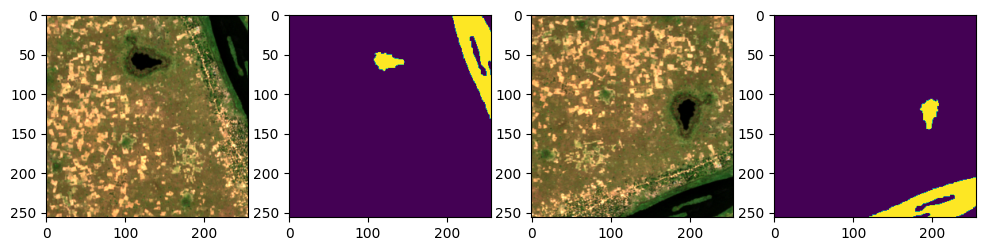

In [15]:
patch_rot, ptruth_rot = rotate(prob=0.5)(patch, ptruth)
fig, ax = plt.subplots(1, 4, figsize=(12,3))
imgShow(patch.transpose(1,2,0), ax=ax[0])
imgShow(ptruth, ax=ax[1])
imgShow(patch_rot.transpose(1,2,0), ax=ax[2])
imgShow(ptruth_rot, ax=ax[3])

#### flip

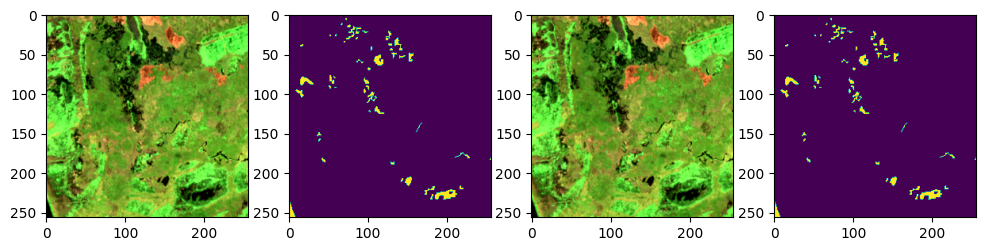

In [28]:
patch_flip, ptruth_flip = flip(prob=0.5)(patch, ptruth)
fig, ax = plt.subplots(1, 4, figsize=(12,3))
imgShow(patch.transpose(1,2,0), ax=ax[0])
imgShow(ptruth, ax=ax[1])
imgShow(patch_flip.transpose(1,2,0), ax=ax[2])
imgShow(ptruth_flip, ax=ax[3])



#### Add noise.

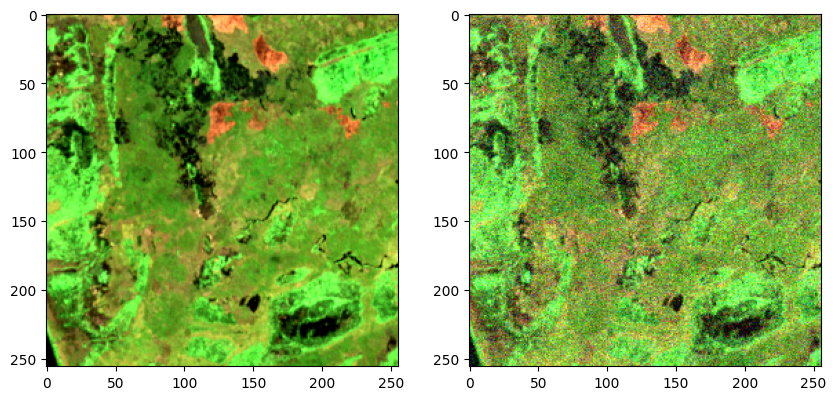

In [32]:
patch_tensor, ptruth_tensor = numpy2tensor()(patch, ptruth)
start = time.time()
std = random.uniform(0.001, 0.01)
noises = torch.normal(mean=0, std=std, size=patch_tensor.shape)
patch_noisy = patch_tensor.add(noises)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
imgShow(patch.transpose(1,2,0), ax=ax[0])
imgShow(patch_noisy.numpy().transpose(1,2,0), ax=ax[1])
